# Intersect PieQTLs with Loops

We saw how Chiou et al., 2021 tried to use co-accessibility of snATAC-seq data in order to link SNPs to genes. Here we will try something very similar but instead use HiChIP data.

In [1]:
import os 
import numpy as np
import pandas as pd
import glob
import subprocess as sp
import json
import warnings
import pybedtools as pbt
import cooler
import seaborn as sns
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
from chromolooper import sgls
import importlib
importlib.reload(sgls)

<module 'chromolooper.sgls' from '/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/projects/chromolooper/chromolooper/sgls.py'>

In [5]:
# change the working directory
os.chdir('/mnt/BioHome/jreyna/jreyna-temp/projects/dchallenge')
pd.set_option('display.max_columns', 1000)

In [6]:
outdir = 'results/main/chiou_2021/analysis/intersect_pieqtls_with_loops/'
os.makedirs(outdir, exist_ok=True)

In [7]:
pbt.set_bedtools_path(sgls.BEDTOOLS_DIR)

## Loading the Chandra et al loops

In [8]:
glob_tmpl = 'results/main/2021_Nikhil_eQTL/Data/FitHiChIP_Loops/*/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed'
chandra_data = []
for fn in glob.glob(glob_tmpl):
    
    celltype = fn.split('/')[5]
    df = pd.read_table(fn)
    df['loop_celltype'] = celltype
    df['loop_source'] = 'chandra_2021'
    chandra_data.append(df)

chandra_data = pd.concat(chandra_data)

In [9]:
# rename col to bedpe format
chandra_data = sgls.rename_col_with_ints(chandra_data, np.arange(0,6), sgls.BEDPE_COLS[0:6])
chandra_data.columns = sgls.add_prefix_to_names(chandra_data.columns, 'loop_')

## Loading the loop catalog loops

In [10]:
glob_tmpl = 'results/main/loop_catalog/processing/hg38_to_hg19/liftover/fit_cp/*.hg19.mcool'

In [11]:
glob_tmpl = 'results/main/loop_catalog/processing/hg38_to_hg19/liftover/*/*.hg19.mcool'
loop_cat_data = []
for fn in glob.glob(glob_tmpl):
    
    file_info = fn.split('/')
    celltype = file_info[7].replace('.hg19.mcool', '')
    source = file_info[6]
    df = sgls.cooler_cli_mcool2bedpe(fn, res=5000)
    df['loop_celltype'] = celltype
    df['loop_source'] = source
    loop_cat_data.append(df)

In [12]:
loop_cat_data = pd.concat(loop_cat_data)

In [13]:
loop_cat_data.columns = sgls.add_prefix_to_names(loop_cat_data.columns.tolist(), 'loop_')

loop_cat_data['loop_score'] /= 100 # divide due to multiplying by 100 in conversion step

In [14]:
loop_cat_data

,loop_chrA,loop_startA,loop_endA,loop_chrB,loop_startB,loop_endB,loop_score,loop_celltype,loop_source
0,chr1,101850000,101855000,chr1,101900000,101905000,4.75,lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1,fit_cp
1,chr1,101850000,101855000,chr1,101905000,101910000,0.68,lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1,fit_cp
2,chr1,101855000,101860000,chr1,101900000,101905000,0.55,lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1,fit_cp
3,chr1,101855000,101860000,chr1,101905000,101910000,0.04,lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1,fit_cp
4,chr1,160390000,160395000,chr1,160515000,160520000,0.28,lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1,fit_cp
...,...,...,...,...,...,...,...,...,...
13291,chr21,46310000,46315000,chr21,46345000,46350000,0.08,GM12878.GSE101498.Homo_Sapiens.H3K27ac.b2,hiccups
13292,chr21,46310000,46315000,chr21,46350000,46355000,3.36,GM12878.GSE101498.Homo_Sapiens.H3K27ac.b2,hiccups
13293,chr21,46970000,46975000,chr21,47235000,47240000,0.07,GM12878.GSE101498.Homo_Sapiens.H3K27ac.b2,hiccups
13294,chr21,46975000,46980000,chr21,47230000,47235000,0.04,GM12878.GSE101498.Homo_Sapiens.H3K27ac.b2,hiccups


## Concate all loop datasets

In [15]:
# add loop IDs
chandra_data['loop_id'] = sgls.create_loop_id_col(chandra_data, extras=tuple([25, 26]))
loop_cat_data['loop_id'] = sgls.create_loop_id_col(loop_cat_data, extras=tuple([7,8]))

# extract interval + id data only for intersection analysis
bedpe_loop_cols = sgls.add_prefix_to_names(sgls.BEDPE_COLS[0:6], 'loop_')
chandra_tmp = chandra_data.loc[:, bedpe_loop_cols + ['loop_id']]
loop_cat_temp = loop_cat_data.loc[:, bedpe_loop_cols + ['loop_id']]

# concat all data
all_loops = pd.concat([chandra_tmp, loop_cat_temp])

In [16]:
# convert loops to pbt 
all_loops_pbt = pbt.BedTool.from_dataframe(all_loops)

## Loading the Extra Jurkat Loops

In [17]:
jurkat_loop_glob = '/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/2020_IQTL_HiChIP/Data/' + \
                    'Jurkat_FitHiChIP_Loops/HiChIP_Samples_*/Out_FitHiChIP/' + \
                    'FitHiChIP_Peak2ALL_b5000_L10000_U3000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/' + \
                    'FitHiChIP.interactions_FitHiC_Q0.01.bed'
jurkat_loop_files = glob.glob(jurkat_loop_glob)
jurkat_loops = sgls.read_multiple_tables_to_df(jurkat_loop_files, header=0)

## Load Significant GWAS

In [19]:
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton']

In [20]:
data = []
gwas = 'results/main/coloc/Data/T1D_GWAS/*/GRCh37/GWAS_input_colocalization_pval_lt_5eMinus8.txt'
for fn in glob.glob(gwas):
    path_info = fn.split('/')
    df = pd.read_table(fn)
    
    if path_info[5] not in major_gwas:
        continue
        
    df['gwas_source'] = path_info[5]
    data.append(df)    
gwas_df = pd.concat(data)
gwas_df['sid'] = gwas_df['CHR'].str.replace('chr', '') + ':' + gwas_df['POS'].astype(str)

# loading finemap data into bedtools
gwas_bed = gwas_df.iloc[:, [0,1,1]]
gwas_bed.columns = ['chrom', 'start', 'end']
gwas_bed['start'] = gwas_bed['start'] - 1
gwas_pbt = pbt.BedTool.from_dataframe(gwas_bed)

## Load pieQTLs

In [18]:
pieqtls = glob.glob('results/main/pieqtls/2021_chandra_et_al/*/proximal.pieqtls.tsv')

pieqtl_data = []
for pieqtl in pieqtls:
    print(pieqtl)
    
    cline = pieqtl.split('/')[-2]
    df = pd.read_table(pieqtl)    
    df['cline'] = cline
    pieqtl_data.append(df) 
    
pieqtl_df = pd.concat(pieqtl_data)
pieqtl_df['Chromosome'] = pieqtl_df['Chromosome']
pieqtl_df.loc[:, 'sid'] = pieqtl_df['Chromosome'].str.replace('chr', '') + ':' + \
                          pieqtl_df['pieQTL.Position'].astype(str)

results/main/pieqtls/2021_chandra_et_al/CD8_T-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/CD4_T-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/NK-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/monocyte_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/B-cell_naive/proximal.pieqtls.tsv


In [24]:
pieqtl_df

,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid
0,rs432206,chr5,64858687,ENSG00000250081.1,CTD-2116N20.1,64782875,1.700000e-29,1.220000e-24,-1.20,G,C,25.19,11.30,0.62,Direct_pieQTL,,CD8_T-cell_naive,5:64858687
1,rs60858693,chr5,64857602,ENSG00000250081.1,CTD-2116N20.1,64782875,1.870000e-29,1.220000e-24,-1.19,ATACTT,A,25.19,11.47,0.75,Direct_pieQTL,,CD8_T-cell_naive,5:64857602
2,rs59969955,chr5,64780090,ENSG00000123219.8,CENPK,64858998,4.450000e-29,2.760000e-24,-1.21,C,CTAAAA,54.17,27.36,5.89,Direct_pieQTL,,CD8_T-cell_naive,5:64780090
3,rs10891301,chr11,111809489,ENSG00000150764.9,DIXDC1,111797868,5.860000e-30,5.610000e-24,1.16,C,T,0.46,3.60,6.60,Direct_pieQTL,,CD8_T-cell_naive,11:111809489
4,rs12225443,chr11,111814931,ENSG00000150764.9,DIXDC1,111797868,5.860000e-30,5.610000e-24,1.16,A,C,0.46,3.60,6.60,Direct_pieQTL,,CD8_T-cell_naive,11:111814931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9036,rs2105987,chr14,107163289,ENSG00000223648.2,IGHV3-64,107114274,5.020000e-05,4.974294e-02,0.58,C,T,34.26,46.98,59.96,Indirect_pieQTL,,B-cell_naive,14:107163289
9037,rs77056943,chr7,76852300,ENSG00000127951.5,FGL2,76829143,8.120000e-05,4.980717e-02,0.70,T,C,4.18,6.58,8.41,Direct_pieQTL,,B-cell_naive,7:76852300
9038,rs139996,chr22,36861320,ENSG00000100350.10,FOXRED2,36903148,6.310000e-05,4.986699e-02,1.12,C,T,2.49,3.74,NaN,Indirect_pieQTL,,B-cell_naive,22:36861320
9039,rs139997,chr22,36861712,ENSG00000100350.10,FOXRED2,36903148,6.310000e-05,4.986699e-02,1.12,G,A,2.49,3.74,NaN,Indirect_pieQTL,,B-cell_naive,22:36861712


## Intersect pieQTLs and Sig GWAS

In [21]:
major_cols = ['ge_source',
             'rsid',
             'chrom',
             'pos',
             'geneid',
             'genename',
             'allele1',
             'allele2',
             'maf',
             'beta_x',
             'se',
             'z',
             'prob',
             'log10bf',
             'mean',
             'sd',
             'mean_incl',
             'sd_incl',
             'pval',
             'gwas_source',
             'pieQTL.ID',
             'Chromosome',
             'pieQTL.Position',
             'Target_geneName',
             'TSS',
             'pvalue',
             'FDR (DICE)',
             'beta_y',
             'ref',
             'alt',
             'Mean.TPM.Homozygous.Reference',
             'Mean.TPM.Heterozygous',
             'Mean.TPM.Homozygous.Alternative',
             'Interaction_type',
             'GWAS.Trait',
             'cline',
             'regionID',
             'GWASLoci',
             'index']

In [22]:
intersect_df = pd.merge(gwas_df, pieqtl_df,
                        left_on=['CHR', 'POS'],
                        right_on=['Chromosome', 'pieQTL.Position'],
                        how='inner')

In [23]:
intersect_df

,CHR,POS,BETA,SE,P,N,gwas_source,sid_x,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid_y
0,chr6,31323409,0.293800,0.038100,1.286000e-14,24250.0,T1D_32005708,6:31323409,rs2523605,chr6,31323409,ENSG00000206344.6,HCG27,31165537,2.140000e-05,8.290324e-03,0.84,T,C,0.97,2.70,3.83,Direct_pieQTL,,monocyte_naive,6:31323409
1,chr6,28324397,0.159900,0.023800,1.877000e-11,24250.0,T1D_32005708,6:28324397,rs213236,chr6,28324397,ENSG00000137185.7,ZSCAN9,28192664,2.140000e-05,1.182572e-02,-0.68,T,C,50.52,45.47,41.05,Indirect_pieQTL,,NK-cell_naive,6:28324397
2,chr6,28324397,0.159900,0.023800,1.877000e-11,24250.0,T1D_32005708,6:28324397,rs213236,chr6,28324397,ENSG00000197062.7,RP5-874C20.3,28234788,5.620000e-05,1.746085e-02,-0.64,T,C,22.50,20.95,18.54,Indirect_pieQTL,,B-cell_naive,6:28324397
3,chr6,28902133,0.156700,0.025900,1.514000e-09,24250.0,T1D_32005708,6:28902133,rs1004062,chr6,28902133,ENSG00000204713.6,TRIM27,28891766,2.580000e-05,9.738841e-03,0.69,G,T,8.34,10.23,11.44,Direct_pieQTL,Body height,monocyte_naive,6:28902133
4,chr6,26573218,-0.131900,0.023600,2.134000e-08,24250.0,T1D_32005708,6:26573218,rs1001687,chr6,26573218,ENSG00000261353.1,CTA-14H9.5,26527291,1.170000e-06,7.160810e-04,-0.65,C,G,3.28,1.98,0.87,Indirect_pieQTL,Education,CD4_T-cell_naive,6:26573218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,chr21,43845092,0.086722,0.014027,6.310000e-10,520580.0,T1D_34012112_Gaulton,21:43845092,rs883868,chr21,43845092,ENSG00000160183.9,TMPRSS3,43816955,2.770000e-11,2.840000e-07,0.81,T,C,0.78,1.29,1.59,Direct_pieQTL,Diabetes mellitus type 1,CD4_T-cell_naive,21:43845092
2138,chr21,43845294,0.086920,0.014023,5.710000e-10,520580.0,T1D_34012112_Gaulton,21:43845294,rs2839508,chr21,43845294,ENSG00000160183.9,TMPRSS3,43816955,5.700000e-16,7.840000e-12,0.92,T,C,1.14,1.78,2.55,Direct_pieQTL,Diabetes mellitus type 1,CD8_T-cell_naive,21:43845294
2139,chr21,43845294,0.086920,0.014023,5.710000e-10,520580.0,T1D_34012112_Gaulton,21:43845294,rs2839508,chr21,43845294,ENSG00000160183.9,TMPRSS3,43816955,2.770000e-11,2.840000e-07,0.81,T,C,0.78,1.29,1.59,Direct_pieQTL,Diabetes mellitus type 1,CD4_T-cell_naive,21:43845294
2140,chr21,43846729,0.100740,0.015422,6.480000e-11,520580.0,T1D_34012112_Gaulton,21:43846729,rs2839509,chr21,43846729,ENSG00000160183.9,TMPRSS3,43816955,6.370000e-08,1.505540e-04,0.81,A,G,1.44,2.02,2.91,Direct_pieQTL,,CD8_T-cell_naive,21:43846729


## Intersect loops with 1D data

#### Intersect with fine-mapped SNPs

In [15]:
# load fine-mapping data
fm_snps = pd.read_table('results/main/chiou_2021/processing/finemapping/finemapping.gaulton.tsv')
fm_snps = sgls.snp2bed_df(fm_snps, 0, 1)
fm_snps.loc[:, 'chr'] = 'chr' + fm_snps.loc[:, 'chr'].astype(str)

In [16]:
# update names
fm_snps.columns = ['chr', 'start', 'end',
                   'rsid','ppa', 'signal_name', 'major_allele',
                   'minor_allele', 'genome_id_hg38', 'pos_hg38']
fm_snps.columns = sgls.add_prefix_to_names(fm_snps.columns, 'snp_')

In [17]:
# make a pbt
fm_snps_tmp = fm_snps.iloc[:, 0:4]
fm_snps_pbt = pbt.BedTool.from_dataframe(fm_snps_tmp)

In [18]:
loops_and_snps = all_loops_pbt.pairtobed(fm_snps_pbt)
loops_and_snps = loops_and_snps.to_dataframe()

In [19]:
loops_and_snps

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes
0,chr1,25290000,25295000,chr1,25355000,25360000,chr1.25290000.25295000.chr1.25355000.25360000....,chr1,25291009,25291010,rs6672420
1,chr1,25290000,25295000,chr1,25355000,25360000,chr1.25290000.25295000.chr1.25355000.25360000....,chr1,25292667,25292668,rs7528484
2,chr1,25290000,25295000,chr1,25355000,25360000,chr1.25290000.25295000.chr1.25355000.25360000....,chr1,25293083,25293084,rs7536201
3,chr1,25290000,25295000,chr1,25355000,25360000,chr1.25290000.25295000.chr1.25355000.25360000....,chr1,25293200,25293201,rs11249212
4,chr1,25290000,25295000,chr1,25355000,25360000,chr1.25290000.25295000.chr1.25355000.25360000....,chr1,25293215,25293216,rs7414934
...,...,...,...,...,...,...,...,...,...,...,...
1125354,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,chr19,47616376,47616377,rs55731973
1125355,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,chr19,47619559,47619560,rs11671638
1125356,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,chr19,47619767,47619768,rs11671656
1125357,chr21,45220000,45225000,chr21,45395000,45400000,chr21.45220000.45225000.chr21.45395000.4540000...,chr21,45399789,45399790,rs2838462


In [20]:
loops_and_snps.thickStart.nunique()

103467

In [21]:
loops_and_snps.blockSizes.nunique()

25857

In [22]:
# extract merging data
loops_and_snps_mergee = loops_and_snps.iloc[:, [6,8,9,10]]
loops_and_snps_mergee.columns = ['loop_id', 'snp_start', 'snp_end', 'rsid']

In [23]:
loops_and_snps_mergee

,loop_id,snp_start,snp_end,rsid
0,chr1.25290000.25295000.chr1.25355000.25360000....,25291009,25291010,rs6672420
1,chr1.25290000.25295000.chr1.25355000.25360000....,25292667,25292668,rs7528484
2,chr1.25290000.25295000.chr1.25355000.25360000....,25293083,25293084,rs7536201
3,chr1.25290000.25295000.chr1.25355000.25360000....,25293200,25293201,rs11249212
4,chr1.25290000.25295000.chr1.25355000.25360000....,25293215,25293216,rs7414934
...,...,...,...,...
1125354,chr19.47580000.47585000.chr19.47615000.4762000...,47616376,47616377,rs55731973
1125355,chr19.47580000.47585000.chr19.47615000.4762000...,47619559,47619560,rs11671638
1125356,chr19.47580000.47585000.chr19.47615000.4762000...,47619767,47619768,rs11671656
1125357,chr21.45220000.45225000.chr21.45395000.4540000...,45399789,45399790,rs2838462


#### Intersect with genes

In [24]:
# load gene coordinates
gene_coords = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.grch37.genes_only.bed.gz', header=None)

In [25]:
gene_coords.columns = ['gene_chr', 'gene_start', 'gene_end', 'gene_strand', 'gene_type', 'gene_id', 'gene_name']

In [26]:
# generate the promoter coordinates
promoter_coords = gene_coords.drop(gene_coords.columns[[1,2,3,4]], axis=1)
promoter_coords['gene_pos'] = sgls.create_promoter_position_col(gene_coords)
promoter_coords = sgls.pos2bed_df(promoter_coords, chrom=0, pos=3)
promoter_coords_tmp = promoter_coords.iloc[:, [0,1,2,3]]
promoter_coords_pbt = pbt.BedTool.from_dataframe(promoter_coords_tmp)

In [27]:
# overlap loops and genes
loops_and_genes = all_loops_pbt.pairtobed(promoter_coords_pbt)
loops_and_genes = loops_and_genes.to_dataframe()

In [28]:
loops_and_genes.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes
0,chr1,710000,715000,chr1,755000,760000,chr1.710000.715000.chr1.755000.760000.TFH.chan...,chr1,714005,714006,ENSG00000228327
1,chr1,710000,715000,chr1,755000,760000,chr1.710000.715000.chr1.755000.760000.TFH.chan...,chr1,714149,714150,ENSG00000237491
2,chr1,710000,715000,chr1,760000,765000,chr1.710000.715000.chr1.760000.765000.TFH.chan...,chr1,714005,714006,ENSG00000228327
3,chr1,710000,715000,chr1,760000,765000,chr1.710000.715000.chr1.760000.765000.TFH.chan...,chr1,714149,714150,ENSG00000237491
4,chr1,710000,715000,chr1,760000,765000,chr1.710000.715000.chr1.760000.765000.TFH.chan...,chr1,763175,763176,ENSG00000230021


In [29]:
# extract merging data
loops_and_genes_mergee = loops_and_genes.iloc[:, [6,8,9,10]]
loops_and_genes_mergee.columns = ['loop_id', 'start', 'end', 'gene_id']

## Find loops with SNP and Gene on different anchors

In [30]:
# merging SNP and gene overlaps
loops_annot = all_loops.merge(loops_and_snps_mergee)
loops_annot = loops_annot.merge(loops_and_genes_mergee)

In [31]:
# labeling the anchor of genes and snps
snp_anchors = sgls.create_anchor_overlap_col(loops_annot, 0,1,2,3,4,5,0,7,8)
gene_anchors = sgls.create_anchor_overlap_col(loops_annot, 0,1,2,3,4,5,0,10, 11)
loops_annot['snp_anchors'] = snp_anchors
loops_annot['gene_anchors'] = gene_anchors
loops_annot['anchor_info'] = loops_annot['snp_anchors'] + '-' + loops_annot['gene_anchors'] 

In [32]:
# extrating SGLs based on anchor labels
sgl_loops = loops_annot.loc[loops_annot['anchor_info'].isin(['A-B', 'B-A']),:]
sgl_loops['loop_dist'] = sgl_loops['loop_startB'] - sgl_loops['loop_startA']

In [33]:
sgl_loops

,loop_chrA,loop_startA,loop_endA,loop_chrB,loop_startB,loop_endB,loop_id,snp_start,snp_end,rsid,start,end,gene_id,snp_anchors,gene_anchors,anchor_info,loop_dist
23,chr1,35655000,35660000,chr1,35730000,35735000,chr1.35655000.35660000.chr1.35730000.35735000....,35734985,35734986,rs59169140,35658745,35658746,ENSG00000116560,B,A,B-A,75000
26,chr1,35655000,35660000,chr1,36030000,36035000,chr1.35655000.35660000.chr1.36030000.36035000....,36032616,36032617,rs2107782,35658745,35658746,ENSG00000116560,B,A,B-A,375000
27,chr1,35655000,35660000,chr1,36035000,36040000,chr1.35655000.35660000.chr1.36035000.36040000....,36037221,36037222,rs6425948,35658745,35658746,ENSG00000116560,B,A,B-A,380000
29,chr1,35655000,35660000,chr1,36105000,36110000,chr1.35655000.35660000.chr1.36105000.36110000....,36106252,36106253,rs584598,35658745,35658746,ENSG00000116560,B,A,B-A,450000
31,chr1,35655000,35660000,chr1,36105000,36110000,chr1.35655000.35660000.chr1.36105000.36110000....,36107509,36107510,rs676614,35658745,35658746,ENSG00000116560,B,A,B-A,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968251,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,47584920,47584921,rs367628896,47617032,47617033,ENSG00000130749,A,B,A-B,35000
968252,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,47584920,47584921,rs367628896,47616530,47616531,ENSG00000142230,A,B,A-B,35000
968253,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,47616376,47616377,rs55731973,47582187,47582188,ENSG00000263555,B,A,B-A,35000
968256,chr19,47580000,47585000,chr19,47615000,47620000,chr19.47580000.47585000.chr19.47615000.4762000...,47619559,47619560,rs11671638,47582187,47582188,ENSG00000263555,B,A,B-A,35000


## Merge back the gene and SNP information

In [34]:
# add full SNP data
fm_snps_short = fm_snps.drop(['snp_chr', 'snp_start', 'snp_end'], axis=1)
fm_snps_short.columns = ['snp_rsid'] + fm_snps_short.columns[1:].tolist()

In [35]:
sgl_loops = sgl_loops.merge(fm_snps_short, left_on='rsid', right_on='snp_rsid')

# re-add full gene data
sgl_loops = sgl_loops.merge(gene_coords[['gene_id', 'gene_name', 'gene_start', 'gene_end', 'gene_strand']])

In [36]:
sgl_loops

,loop_chrA,loop_startA,loop_endA,loop_chrB,loop_startB,loop_endB,loop_id,snp_start,snp_end,rsid,start,end,gene_id,snp_anchors,gene_anchors,anchor_info,loop_dist,snp_rsid,snp_ppa,snp_signal_name,snp_major_allele,snp_minor_allele,snp_genome_id_hg38,snp_pos_hg38,gene_name,gene_start,gene_end,gene_strand
0,chr1,35655000,35660000,chr1,35730000,35735000,chr1.35655000.35660000.chr1.35730000.35735000....,35734985,35734986,rs59169140,35658745,35658746,ENSG00000116560,B,A,B-A,75000,rs59169140,0.001126,PSMB2_1:36087661:C:A,AAGTGCATCTTT,A,1:35269385:AAGTGCATCTTT:A,35269385,SFPQ,35641979,35658746,-
1,chr1,35655000,35660000,chr1,35730000,35735000,chr1.35655000.35660000.chr1.35730000.35735000....,35734985,35734986,rs59169140,35658745,35658746,ENSG00000116560,B,A,B-A,75000,rs59169140,0.001126,PSMB2_1:36087661:C:A,AAGTGCATCTTT,A,1:35269385:AAGTGCATCTTT:A,35269385,SFPQ,35641979,35658746,-
2,chr1,35655000,35660000,chr1,35730000,35735000,chr1.35655000.35660000.chr1.35730000.35735000....,35734985,35734986,rs59169140,35658745,35658746,ENSG00000116560,B,A,B-A,75000,rs59169140,0.001126,PSMB2_1:36087661:C:A,AAGTGCATCTTT,A,1:35269385:AAGTGCATCTTT:A,35269385,SFPQ,35641979,35658746,-
3,chr1,35655000,35660000,chr1,35730000,35735000,chr1.35655000.35660000.chr1.35730000.35735000....,35734985,35734986,rs59169140,35658745,35658746,ENSG00000116560,B,A,B-A,75000,rs59169140,0.001126,PSMB2_1:36087661:C:A,AAGTGCATCTTT,A,1:35269385:AAGTGCATCTTT:A,35269385,SFPQ,35641979,35658746,-
4,chr1,35655000,35660000,chr1,35730000,35735000,chr1.35655000.35660000.chr1.35730000.35735000....,35734985,35734986,rs59169140,35658745,35658746,ENSG00000116560,B,A,B-A,75000,rs59169140,0.001126,PSMB2_1:36087661:C:A,AAGTGCATCTTT,A,1:35269385:AAGTGCATCTTT:A,35269385,SFPQ,35641979,35658746,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515303,chr8,119960000,119965000,chr8,120080000,120085000,chr8.119960000.119965000.chr8.120080000.120085...,120084407,120084408,rs2450081,119964123,119964124,ENSG00000164761,B,A,B-A,120000,rs2450081,0.111021,COLEC10_8:120082941:A:C,T,C,8:119072169:T:C,119072169,TNFRSF11B,119935796,119964124,-
515304,chr8,119960000,119965000,chr8,120085000,120090000,chr8.119960000.119965000.chr8.120085000.120090...,120086851,120086852,rs2465397,119964123,119964124,ENSG00000164761,B,A,B-A,125000,rs2465397,0.064138,COLEC10_8:120082941:A:C,A,G,8:119074613:A:G,119074613,TNFRSF11B,119935796,119964124,-
515305,chr8,119960000,119965000,chr8,120085000,120090000,chr8.119960000.119965000.chr8.120085000.120090...,120087777,120087778,rs2450079,119964123,119964124,ENSG00000164761,B,A,B-A,125000,rs2450079,0.032606,COLEC10_8:120082941:A:C,G,C,8:119075539:G:C,119075539,TNFRSF11B,119935796,119964124,-
515306,chr8,119960000,119965000,chr8,120085000,120090000,chr8.119960000.119965000.chr8.120085000.120090...,120088834,120088835,rs1905775,119964123,119964124,ENSG00000164761,B,A,B-A,125000,rs1905775,0.002500,COLEC10_8:120082941:A:C,A,G,8:119076596:A:G,119076596,TNFRSF11B,119935796,119964124,-


In [37]:
# convert chandra q-values to -log10(q-value)
chandra_data['loop_score'] = -1 * np.log(chandra_data['loop_Q-Value_Bias'])

In [38]:
# merging loop scores with sgls
chandra_data_scores = chandra_data[['loop_id', 'loop_celltype', 'loop_source', 'loop_score']]
loop_cat_scores = loop_cat_data[['loop_id', 'loop_celltype', 'loop_source', 'loop_score']]
loop_scores = pd.concat([chandra_data_scores, loop_cat_scores])
sgl_loops = sgl_loops.merge(loop_scores)

## Investigate the loops, SNPs and genes (ALL Loop Calls)

#### Plot the relationship between PPA and loop score

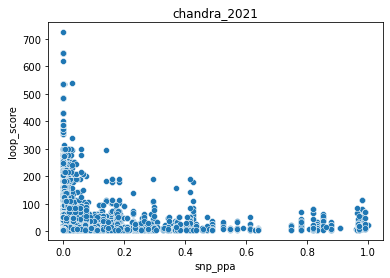

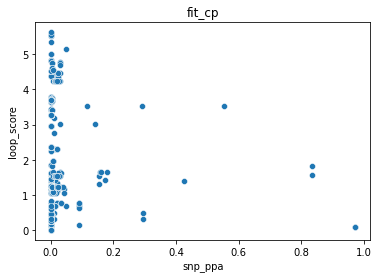

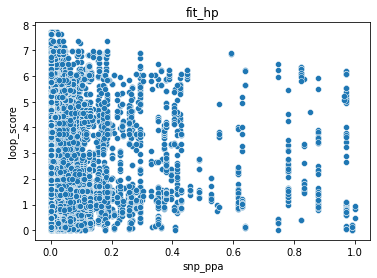

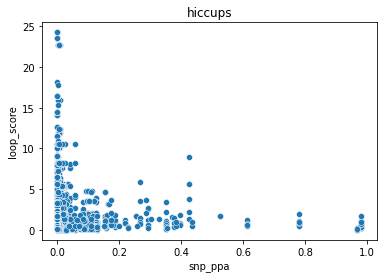

In [39]:
loop_grps = sgl_loops.groupby('loop_source')

for name, grp_df in loop_grps:
    tdf = loop_grps.get_group(name)
    fig, ax = plt.subplots()
    ax.set_title(name)
    sns.scatterplot(x='snp_ppa', y='loop_score', data=grp_df, ax=ax)

The pattern is a bit odd....as PPA goes up, loop -log10(q-value/p-value) score goes down. Why?

#### Plotting the distance of all loops

In [40]:
sgl_loops.loop_dist.describe()

count    5.153080e+05
mean     4.392735e+05
std      5.214242e+05
min      1.000000e+04
25%      8.500000e+04
50%      2.200000e+05
75%      6.450000e+05
max      8.080000e+06
Name: loop_dist, dtype: float64

<AxesSubplot:xlabel='loop_dist', ylabel='Count'>

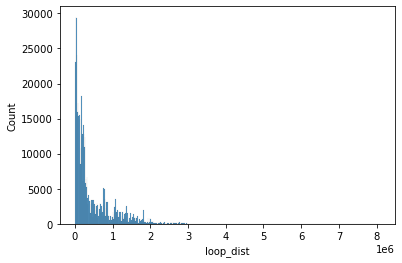

In [41]:
sns.histplot(data=sgl_loops, x='loop_dist')

Most loops are sub 1mb

#### plot the relationship between loop distance and PPA

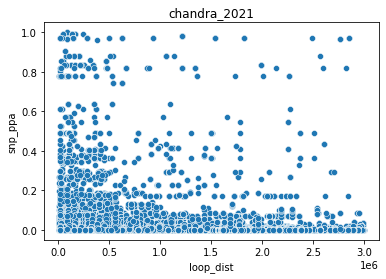

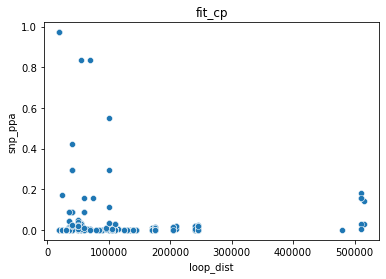

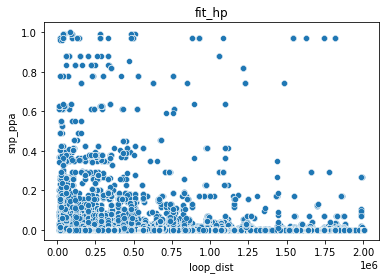

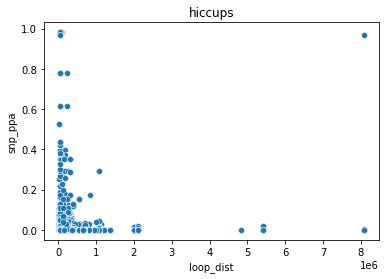

In [42]:
loop_grps = sgl_loops.groupby('loop_source')

for name, grp_df in loop_grps:
    tdf = loop_grps.get_group(name)
    fig, ax = plt.subplots()
    ax.set_title(name)
    sns.scatterplot(x='loop_dist', y='snp_ppa', data=grp_df, ax=ax)

Not a hub pattern between loop distance and PPA.

## Adding additional 1D and 3D information

To start, I will filter the loops for those belonging to a select group of samples, more details below. Then I will add  add gene expression data, followed by PC-HiC information and finally snATAC-seq data. Note, the most important step in all of this is to left merge so as to keep every single loop. 

#### Loading cell type information for each cell type/assay

In [76]:
cell_meta = pd.read_table('results/refs/meta/cell_types.dict.tsv')

# replace float(nan) with string nan 
cell_meta.loc[:, 'color-name'] = cell_meta['color-name'].replace(np.nan, 'nan')

In [77]:
cell_meta

,source,source-name,full-name,project-name,color-name
0,JR,B cell,B cell,b-cell,b-cell
1,JR,T-cell,T-cell,t-cell,nan
2,JR,CD4+T-cell,CD4+T-cell,cd4t-cell,cd4t-cell
3,JR,CD8+T-cell,CD8+T-cell,cd8t-cell,cd4t-cell
4,JR,Monocyte,Monocyte,monocyte,monocyte
...,...,...,...,...,...
70,Loop Catalog,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1,cd4t-cell
71,Loop Catalog,Th17.GSE101498.Homo_Sapiens.H3K27ac.b2,Th17.GSE101498.Homo_Sapiens.H3K27ac.b2,Th17.GSE101498.Homo_Sapiens.H3K27ac.b2,cd4t-cell
72,Loop Catalog,Treg.GSE101498.Homo_Sapiens.H3K27ac.b1,Treg.GSE101498.Homo_Sapiens.H3K27ac.b1,Treg.GSE101498.Homo_Sapiens.H3K27ac.b1,cd4t-cell
73,Loop Catalog,Treg.GSE101498.Homo_Sapiens.H3K27ac.b2,Treg.GSE101498.Homo_Sapiens.H3K27ac.b2,Treg.GSE101498.Homo_Sapiens.H3K27ac.b2,cd4t-cell


**Extract loops from a select list**

This main list was made by hand using:  
```
# for Chandra et al 2021
tdf = chandra_data[['loop_celltype', 'loop_source']].drop_duplicates()
tdf = tdf.sort_values(by=['loop_celltype', 'loop_source']).values.tolist()
tdf

# for loop catalog
tdf = loop_cat_data[['loop_celltype', 'loop_source']].drop_duplicates()
tdf = tdf.sort_values(by=['loop_celltype', 'loop_source']).values.tolist()
print(tdf)
```

And then filtering by hand. I prioritized samples using fit_cp > hiccups > fit_hp. The reason that fit_hp comes last is that in the correlation analyses I didn't above, fit_hp didn't seem to follow the pattern of the rest. 

In [44]:
main_samples = [['GM12878.GSE101498.Homo_Sapiens.H3K27ac.b1', 'hiccups'],
 ['GM12878.GSE101498.Homo_Sapiens.H3K27ac.b2', 'hiccups'],
 ['HARA.GSE147854.Homo_Sapiens.H3K27ac.b1', 'fit_hp'],    
 ['MyLa.GSE101498.Homo_Sapiens.H3K27ac.b1', 'hiccups'],
 ['MyLa.GSE101498.Homo_Sapiens.H3K27ac.b2', 'hiccups'],
 ['MyLa.GSE137906.Homo_Sapiens.H3K27ac.b1', 'hiccups'],
 ['MyLa.GSE151193.Homo_Sapiens.H3K27ac.b1', 'hiccups'],
 ['Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b1', 'fit_hp'],
 ['Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2', 'hiccups'],
 ['Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b3', 'hiccups'],
 ['Th17.GSE101498.Homo_Sapiens.H3K27ac.b1', 'hiccups'],
 ['Th17.GSE101498.Homo_Sapiens.H3K27ac.b2', 'hiccups'],
 ['Th17.GSE101498.Homo_Sapiens.H3K27ac.b3', 'hiccups'],
 ['Treg.GSE101498.Homo_Sapiens.H3K27ac.b1', 'fit_hp'],
 ['Treg.GSE101498.Homo_Sapiens.H3K27ac.b2', 'hiccups'],
 ['Treg.GSE101498.Homo_Sapiens.H3K27ac.b3', 'hiccups'],       
 ['lgs000379.GSE116193.Homo_Sapiens.H3K27ac.b1', 'fit_cp'],
 ['lgs101645.GSE116193.Homo_Sapiens.H3K27ac.b1', 'fit_cp'],
 ['lgs102580.GSE116193.Homo_Sapiens.H3K27ac.b1', 'fit_cp'],
 ['lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1', 'fit_cp'],                
 ['lgs301283.GSE116193.Homo_Sapiens.H3K27ac.b1', 'fit_cp'],
 ['lgs301315.GSE116193.Homo_Sapiens.H3K27ac.b1', 'fit_cp'],
 ['CD4N', 'chandra_2021'],
 ['CD8N', 'chandra_2021'],
 ['CM', 'chandra_2021'],
 ['NB', 'chandra_2021'],
 ['NCM', 'chandra_2021'],
 ['NK', 'chandra_2021']]
main_samples = pd.DataFrame(main_samples)
main_samples.columns = ['loop_celltype', 'loop_source']

# filter samples via merging
main_sgls = sgl_loops.merge(main_samples)

In [45]:
main_sgls = main_sgls.loc[main_sgls.snp_ppa > 0.1, :]
main_sgls = main_sgls.loc[main_sgls.loop_score > 1.3, :]

In [ ]:
main_sgls

In [ ]:
7 + 

#### Integrate gene expression

In [46]:
# loading expression data
main_list = ['NK', 'CM', 'CD4N', 'CD8N', 'NB']
main_list_wprefix = sgls.add_prefix_to_names(main_list, 'gexpr_')
expr_dataset = []
for fn in glob.glob('results/main/dice_gene_expression/*.csv'):
    cline = os.path.basename(fn).split('_')[0]
    if cline in main_list:
        
        df = pd.read_table(fn, sep=',')
        meds = np.median(df.values[:, 3:], axis=1)
        simple_df = df.iloc[:, [0]]
        simple_df.insert(1, cline, meds)
        simple_df.set_index('Feature_name', inplace=True)
        expr_dataset.append(simple_df)
expr = pd.concat(expr_dataset, axis=1)

# remove versioned gene id 
expr.index = expr.index.str.replace('\.[0-9]*', '')

# add prefixes to gene expression data
expr.columns = sgls.add_prefix_to_names(expr.columns, 'gexpr_')

In [47]:
# merge the ge data
main_sgls = main_sgls.merge(expr, left_on='gene_id', right_index=True)
main_sgls['gexpr_in_any'] = (main_sgls[main_list_wprefix] > 10).sum(axis=1) > 0

#### Integrate PC-HiC Data

In [78]:
javierre_cells = cell_meta.loc[(cell_meta['source'] == 'Javierre et al., 2016') & \
                               (cell_meta['color-name'] != 'nan')]

In [79]:
javierre_cells

,source,source-name,full-name,project-name,color-name
6,"Javierre et al., 2016",Mon,Monocyte,monocyte,monocyte
16,"Javierre et al., 2016",nCD4,CD4+ T-cell,cd4t-cell,cd4t-cell
17,"Javierre et al., 2016",tCD4,Total CD4+ T-cell,total-cd4t-cell,cd4t-cell
18,"Javierre et al., 2016",aCD4,Activated CD4+ T-cell,activated-cd4t-cell,cd4t-cell
19,"Javierre et al., 2016",naCD4,Non-activated CD4+ T-cell,nonactivated-cd4t-cell,cd4t-cell
20,"Javierre et al., 2016",nCD8,CD8+ T-cell,cd8t-cell,cd8t-cell
21,"Javierre et al., 2016",tCD8,Total CD8+ T-cell,total-cd8t-cell,cd8t-cell
22,"Javierre et al., 2016",nB,B cell,b-cell,b-cell
23,"Javierre et al., 2016",tB,Total B cell,total-b-cell,b-cell


In [51]:
# extract a list of Javierre et al., 2016 data
tmpl = 'results/main/pc_hic/2016_javierre/processing/{project_name}.bedpe'
pchic_fns = [tmpl.format(project_name=x) for x in javierre_cells['project-name'].tolist()]

In [137]:
main_sources = ['Chandra et al., 2021', 'Loop Catalog']
main_cells = cell_meta.loc[cell_meta['source-name'].isin(main_sgls['loop_celltype'].unique()) &
                           cell_meta['source'].isin(main_sources)]

In [147]:
color_names_selected = [('monocyte', 'monocyte'),
                         ('b-cell', 'b-cell'),
                         ('cd4t-cell', 'cd4t-cell'),
                         ('cd8t-cell', 'cd8t-cell'),
                         ('t-cell', 'cd4t-cell'),
                         ('t-cell', 'cd8t-cell')]

In [ ]:
# function to get the pchi
parse_pchic_fn = lambda x: os.path.basename(x).split('.')[0]

# nested for loop for 2D combining 
added_javierre = []
for main_grp, main_df in main_sgls.groupby(['loop_celltype', 'loop_source']):
    
    print(main_grp)
    
    # get information about the main cell 
    if main_grp[1] == 'chandra_2021':
        main_cell = cell_meta.loc[(cell_meta['source-name'] == main_grp[0]) &
                       (cell_meta['source'] == 'Chandra et al., 2021')].iloc[0]        
    else:
        main_cell = cell_meta.loc[(cell_meta['source-name'] == main_grp[0]) &
                       (cell_meta['source'] == 'Loop Catalog')].iloc[0]

    # get the pbt for the current main data
    main_pbt = pbt.BedTool.from_dataframe(main_df.iloc[:, 0:7])
    
    # inner loop for PCHiC data
    for fn in pchic_fns:
         
        pchic_cell = parse_pchic_fn(fn)
        pchic_cell = cell_meta.loc[(cell_meta['project-name'] == pchic_cell) &
                       (cell_meta['source'] == 'Javierre et al., 2016')].iloc[0] 

        if (main_cell['color-name'], pchic_cell['color-name']) in color_names_selected:
        
            print('\t', fn)

            pchic = pd.read_table(fn)
            
            # rename the columns to BEDPE format
            pchic = sgls.rename_col_with_ints(pchic, np.arange(0,7), sgls.BEDPE_COLS[0:6] + ['chicago'])
            
            # add the loop id
            pchic['loop_id'] = sgls.create_loop_id_col(pchic)
            
            # add javierre prefix
            pchic.columns = sgls.add_prefix_to_names(pchic.columns, 'javierre_')
            pchic_pb_cols = sgls.range_list(0,6) + [7]
            pchic_pbt = pbt.BedTool.from_dataframe(pchic.iloc[:, pchic_pb_cols])
            
            # pairtopair
            ptp = main_pbt.pairtopair(pchic_pbt)
            ptp_df = ptp.to_dataframe(disable_auto_names=False, header=None)
            ptp_df = ptp_df.iloc[:, [6, 13]]
            ptp_df.columns = ['main_loop_id', 'javierre_loop_id']

            # adding back annotation information
            new_main_df = main_df.merge(ptp_df, left_on='loop_id', right_on='main_loop_id', how='left')
            new_main_df = new_main_df.merge(pchic, on='javierre_loop_id')
            
            # extracting the best overlap for each loop
            best_overlaps = sgls.optimal_samples_from_groupby(new_main_df, 'loop_id', 'javierre_chicago', max)
            best_overlaps['javierre_celltype'] = pchic_cell['project-name']
            
            added_javierre.append(best_overlaps)
            

('CD4N', 'chandra_2021')
	 results/main/pc_hic/2016_javierre/processing/monocyte.bedpe
	 results/main/pc_hic/2016_javierre/processing/cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/total-cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/activated-cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/nonactivated-cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/cd8t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/total-cd8t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/b-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/total-b-cell.bedpe
('CD8N', 'chandra_2021')
	 results/main/pc_hic/2016_javierre/processing/monocyte.bedpe
	 results/main/pc_hic/2016_javierre/processing/cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/total-cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/activated-cd4t-cell.bedpe
	 results/main/pc_hic/2016_javierre/processing/nonactivated-cd4t-cell.bedpe
	 resu

In [274]:
main_with_javierre = pd.concat(added_javierre)

In [281]:
# def get_AorB(sr, anchor_col, ab_col, left_cols, right_cols):
#     """
#     Extract either the A or B segment. 
#     """
    
#     if sr[anchor_col] == 'A':
#         if sr[ab_col] == 'A-B':
#             return(sr[left_cols])
#         else:
#             return(sr[right_cols])
        
#     elif sr[anchor_col] == 'B':
#         if sr[ab_col] == 'A-B':
#             return(sr[right_cols])
#         else:
#             return(sr[left_cols])
#     else:
#         raise Exception('Problem with AorB')       

In [360]:
mergee_cols = ['loop_id'] + sgls.extract_cols_with_prefixes(main_with_javierre.columns.tolist(), 'javierre_')
main_with_javierre_mergee = main_with_javierre[mergee_cols]

In [365]:
main_sgls = main_sgls.merge(main_with_javierre_mergee, how='left')

In [370]:
main_sgls2 = main_sgls.drop_duplicates(['loop_id', 'gene_id', 'snp_rsid'])

In [612]:
# extract the strongest SGLs from the main SGLs
strongest_sgls = main_sgls2.loc[(main_sgls2['gexpr_in_any'] == True) & 
                                (main_sgls2['javierre_chicago'] > 5)]
# remove non-gene rna's
strongest_sgls = strongest_sgls.loc[~strongest_sgls.gene_name.str.match('^AL.*\.[0-9]+$')]

In [613]:
strongest_sgls.gene_name.value_counts()

ZFP36L1     21
EIF4A1      14
IKZF1       11
PFDN5        9
LSP1         8
AAAS         7
C12orf10     7
MPDU1        7
ATXN2L       7
MIR623       6
POLR2A       6
ZBTB4        6
FLI1         6
SH2B3        5
TCP1         5
MRPL18       5
EZR-AS1      5
SYTL3        5
WRAP53       4
RO60         4
UCHL5        4
CHRAC1       4
TNFSF13      4
FCMR         4
SFPQ         4
RBM17        3
DUSP22       3
TRIB2        3
HUS1         3
TASOR2       3
TNFAIP3      2
FXR2         2
GPR18        2
HIPK1        2
AP4B1        2
IKBKE        2
CCR7         2
WIPI1        2
PRKD2        2
MDN1         2
IFNGR1       2
ICAM1        2
PCBD1        1
NSL1         1
TATDN3       1
AGO4         1
ZNF646       1
BCL2L11      1
TP53         1
C1orf216     1
SGF29        1
NFATC2IP     1
YOD1         1
PFKFB3       1
Name: gene_name, dtype: int64

In [614]:
strongest_sgls.gene_name.nunique()

54

#### Integrate ATAC-seq data

In [615]:
fns = 'results/main/chiou_2021/processing/*.bed'
atac = sgls.read_multiple_tables_to_df(glob.glob(fns))
atac.columns = sgls.add_prefix_to_names(['chr', 'start', 'end', 'file'], 'atac_')

In [616]:
# extract cell type 
celltype_func = lambda x: os.path.basename(x).split('.')[0]
atac['atac_celltype'] = atac.atac_file.apply(celltype_func)

# creating ATAC pbt
atac_pbt = pbt.BedTool.from_dataframe(atac.iloc[:, [0,1,2,4]])

In [617]:
# creating strongest_sgl pbt 
strongest_snps = strongest_sgls[['loop_chrA', 'snp_start', 'snp_end', 'snp_rsid']].drop_duplicates('snp_rsid')
strongest_snps_pbt = pbt.BedTool.from_dataframe(strongest_snps)

In [618]:
# intersect atac and snps
atac_snps = strongest_snps_pbt.intersect(atac_pbt, wa=True, wb=True)
atac_snps_df = atac_snps.to_dataframe()

# rename columns
cols = sgls.add_prefix_to_names(sgls.BED_COLS + ['rsid'], 'snp_') + \
        sgls.add_prefix_to_names(sgls.BED_COLS + ['celltype'], 'atac_')
atac_snps_df.columns = cols

In [619]:
# add overlap
atac_snps_df['overlap'] = True

# pivote on overlap
atac_snps_df = atac_snps_df.pivot(index=['snp_rsid', 'atac_start', 'atac_end'],
                                   columns=['atac_celltype'], values='overlap')

In [620]:
# replace na with True 
atac_snps_df = ~atac_snps_df.isna()

# rename olumns with a atac prefix
atac_snps_df.columns = sgls.add_prefix_to_names(atac_snps_df.columns, 'atac_')
atac_snps_df['atac_any'] = True

In [621]:
atac_snps_df = atac_snps_df.reset_index()

In [622]:
# merge with strongest sgls
strongest_sgls2 = strongest_sgls.merge(atac_snps_df, on='snp_rsid', how='left')
strongest_sgls2.loc[:, 'atac_any'] = ~strongest_sgls2['atac_any'].isna()

# extracting the strongest sgls with ATAC-seq overlap
strongest_atac_sgls = strongest_sgls2.loc[strongest_sgls2.atac_any == True]

In [631]:
strongest_atac_sgls.gene_name.value_counts()

IKZF1       9
LSP1        8
PFDN5       7
FLI1        6
C12orf10    6
ATXN2L      6
ZFP36L1     6
AAAS        5
SFPQ        4
RO60        4
UCHL5       4
FCMR        4
HUS1        3
CCR7        2
RBM17       2
MDN1        2
WIPI1       2
TASOR2      2
EIF4A1      2
PFKFB3      1
POLR2A      1
ZBTB4       1
NFATC2IP    1
TNFSF13     1
C1orf216    1
EZR-AS1     1
DUSP22      1
ZNF646      1
MPDU1       1
TCP1        1
MRPL18      1
SYTL3       1
TNFAIP3     1
Name: gene_name, dtype: int64

In [649]:
main_cols = [
 'snp_rsid',
 'snp_ppa',
 'snp_signal_name',
 'snp_major_allele',
 'snp_minor_allele',
 'gene_name',
 'gexpr_NK',
 'gexpr_CM',
 'gexpr_CD4N',
 'gexpr_CD8N',
 'gexpr_NB',
 'loop_score',    
 'loop_dist',
 'loop_celltype',
 'loop_source',
 'javierre_chicago',
 'javierre_celltype',
 'atac_activated-cd4t-cell',
 'atac_adaptive-nk-cell',
 'atac_b-cell',
 'atac_cyto-nk-cell',
 'atac_dendrictic',
 'atac_mem-b-cell',
 'atac_mem-cd8t-cell',
 'atac_monocyte',
 'atac_non-class-monocyte',
 'atac_pancreatic-cd8t-cell',
 'atac_pancreatic-macrophage',
 'atac_treg',
 'loop_id',
 'loop_chrA',
 'loop_startA',
 'loop_endA',
 'loop_chrB',
 'loop_startB',
 'loop_endB',
 'snp_start',
 'snp_end',
 'rsid',
 'start',
 'end',
 'gene_id',
 'snp_anchors',
 'gene_anchors',
 'anchor_info',
 'snp_genome_id_hg38',
 'snp_pos_hg38',
 'gene_start',
 'gene_end',
 'gene_strand',
 'gexpr_in_any',
 'javierre_loop_id',
 'javierre_chrA',
 'javierre_startA',
 'javierre_endA',
 'javierre_chrB',
 'javierre_startB',
 'javierre_endB',
 'atac_start',
 'atac_end',
 'atac_any']

In [650]:
strong_fn = os.path.join(outdir, 'strongest_atac_sgls.tsv')
sgls.df_to_tsv_file(strongest_atac_sgls[main_cols], strong_fn)

True

In [645]:
s = "Z:/Groups/vd-ay/jreyna/projects/dchallenge"

In [647]:
s + '/' + strong_fn

'Z:/Groups/vd-ay/jreyna/projects/dchallenge/results/main/chiou_2021/analysis/intersect_cs_with_loops/strongest_atac_sgls.tsv'

In [634]:
strong_fn

'results/main/chiou_2021/analysis/intersect_cs_with_loops/strongest_atac_sgls.tsv'

#### Other

In [ ]:
# sgl_fn = os.path.join(outdir, 'sgls.tsv')
# sgls.df_to_tsv_file(main_sgls2, sgl_fn, header=True);

## Jurkat expression data

In [715]:
jurkat_dir = '/mnt/BioHome/jreyna/jreyna-temp/projects/20220323_Jurkat_Expression/cline_expression/'

# loading Cassioli data
cas_fn = os.path.join(jurkat_dir, 'results/Cassioli_2021/log_tpm1_dump.tsv')
cas = pd.read_table(cas_fn)
cas['jurkat_gexpr_source'] = 'cassioli'

# loading Ghandi data
ghandi_fn = os.path.join(jurkat_dir, 'results/Ghandi_2019/log_tpm1_dump.tsv')
ghandi = pd.read_table(ghandi_fn)
ghandi['jurkat_gexpr_source'] = 'ghandi'

# concatenating the data
jurkat_gexpr = pd.concat([cas, ghandi])

In [716]:
#10**(-jurkat_gexpr['log_tpm_p1']) - 1
#jurkat_gexpr['tpm'] = np.exp(jurkat_gexpr['log_tpm_p1'] - 1, )

In [717]:
# subset matrix for merging the most important information
jurkat_gexpr_mergee = jurkat_gexpr[['geneid', 'log_tpm_p1', 'jurkat_gexpr_source']]
jurkat_gexpr_mergee.columns = sgls.add_prefix_to_names(jurkat_gexpr_mergee, 'jurkat_gexpr_')

In [718]:
# drop duplicates, keep the max expression only 
jurkat_gexpr_mergee = jurkat_gexpr_mergee.sort_values('jurkat_gexpr_source', ascending=False)
jurkat_gexpr_mergee = jurkat_gexpr_mergee.drop_duplicates(subset=['jurkat_gexpr_geneid'],
                                                                keep='first')

In [719]:
# merge SGLs with Jurkat expression
strongest_atac_sgls_jurkat = strongest_atac_sgls.merge(jurkat_gexpr_mergee,
                                                       left_on='gene_id',
                                                       right_on='jurkat_gexpr_geneid',
                                                       how='left')

In [720]:
strongest_atac_sgls_jurkat.shape

(98, 64)

In [721]:
strongest_atac_sgls_jurkat.loc[strongest_atac_sgls_jurkat.jurkat_gexpr_log_tpm_p1 > 1]

,loop_chrA,loop_startA,loop_endA,loop_chrB,loop_startB,loop_endB,loop_id,snp_start,snp_end,rsid,start,end,gene_id,snp_anchors,gene_anchors,anchor_info,loop_dist,snp_rsid,snp_ppa,snp_signal_name,snp_major_allele,snp_minor_allele,snp_genome_id_hg38,snp_pos_hg38,gene_name,gene_start,gene_end,gene_strand,loop_celltype,loop_source,loop_score,gexpr_NK,gexpr_CM,gexpr_CD4N,gexpr_CD8N,gexpr_NB,gexpr_in_any,javierre_loop_id,javierre_chrA,javierre_startA,javierre_endA,javierre_chrB,javierre_startB,javierre_endB,javierre_chicago,javierre_celltype,atac_start,atac_end,atac_activated-cd4t-cell,atac_adaptive-nk-cell,atac_b-cell,atac_cyto-nk-cell,atac_dendrictic,atac_mem-b-cell,atac_mem-cd8t-cell,atac_monocyte,atac_non-class-monocyte,atac_pancreatic-cd8t-cell,atac_pancreatic-macrophage,atac_treg,atac_any,jurkat_gexpr_geneid,jurkat_gexpr_log_tpm_p1,jurkat_gexpr_source
0,chr1,35655000,35660000,chr1,36105000,36110000,chr1.35655000.35660000.chr1.36105000.36110000....,36107509,36107510,rs676614,35658745,35658746,ENSG00000116560,B,A,B-A,450000,rs676614,0.186331,PSMB2_1:36087661:C:A,C,A,1:35641909:C:A,35641909,SFPQ,35641979,35658746,-,NCM,chandra_2021,8.520943,351.546001,343.866506,545.604319,512.858766,688.853565,True,chr1.35656943.35666673.chr1.36105818.36106152,chr1,35656943.0,35666673.0,chr1,36105818.0,36106152.0,5.311137,monocyte,36106628.0,36107884.0,True,True,True,True,True,True,True,True,True,True,True,True,True,ENSG00000116560,8.573723,ghandi
1,chr1,35655000,35660000,chr1,36105000,36110000,chr1.35655000.35660000.chr1.36105000.36110000....,36107509,36107510,rs676614,35658745,35658746,ENSG00000116560,B,A,B-A,450000,rs676614,0.186331,PSMB2_1:36087661:C:A,C,A,1:35641909:C:A,35641909,SFPQ,35641979,35658746,-,CD8N,chandra_2021,39.359564,351.546001,343.866506,545.604319,512.858766,688.853565,True,chr1.35656943.35666673.chr1.36105818.36106152,chr1,35656943.0,35666673.0,chr1,36105818.0,36106152.0,6.327721,cd8t-cell,36106628.0,36107884.0,True,True,True,True,True,True,True,True,True,True,True,True,True,ENSG00000116560,8.573723,ghandi
2,chr1,35655000,35660000,chr1,36105000,36110000,chr1.35655000.35660000.chr1.36105000.36110000....,36107509,36107510,rs676614,35658745,35658746,ENSG00000116560,B,A,B-A,450000,rs676614,0.186331,PSMB2_1:36087661:C:A,C,A,1:35641909:C:A,35641909,SFPQ,35641979,35658746,-,CM,chandra_2021,9.450931,351.546001,343.866506,545.604319,512.858766,688.853565,True,chr1.35656943.35666673.chr1.36105818.36106152,chr1,35656943.0,35666673.0,chr1,36105818.0,36106152.0,5.311137,monocyte,36106628.0,36107884.0,True,True,True,True,True,True,True,True,True,True,True,True,True,ENSG00000116560,8.573723,ghandi
3,chr1,35655000,35660000,chr1,36105000,36110000,chr1.35655000.35660000.chr1.36105000.36110000....,36107509,36107510,rs676614,35658745,35658746,ENSG00000116560,B,A,B-A,450000,rs676614,0.186331,PSMB2_1:36087661:C:A,C,A,1:35641909:C:A,35641909,SFPQ,35641979,35658746,-,CD4N,chandra_2021,49.003953,351.546001,343.866506,545.604319,512.858766,688.853565,True,chr1.35656943.35666673.chr1.36103205.36105817,chr1,35656943.0,35666673.0,chr1,36103205.0,36105817.0,5.993977,cd4t-cell,36106628.0,36107884.0,True,True,True,True,True,True,True,True,True,True,True,True,True,ENSG00000116560,8.573723,ghandi
4,chr1,192515000,192520000,chr1,193025000,193030000,chr1.192515000.192520000.chr1.193025000.193030...,192515777,192515778,rs10489869,193029209,193029210,ENSG00000116750,A,B,A-B,510000,rs10489869,0.100998,RGS1_1:192515849:A:G,G,A,1:192546648:G:A,192546648,UCHL5,192981380,193029210,-,NCM,chandra_2021,10.421896,36.217095,10.376136,22.275635,20.099229,15.268359,True,chr1.193025896.193031393.chr1.192516025.192527270,chr1,193025896.0,193031393.0,chr1,192516025.0,192527270.0,6.638899,monocyte,192515772.0,192516242.0,True,False,False,False,False,False,False,False,False,False,False,False,True,ENSG00000116750,5.241840,ghandi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [722]:
jurkat_main_cols = [
 'snp_rsid',
 'snp_ppa',
 'snp_signal_name',
 'snp_major_allele',
 'snp_minor_allele',
 'gene_name',
 'gexpr_NK',
 'gexpr_CM',
 'gexpr_CD4N',
 'gexpr_CD8N',
 'gexpr_NB',
 'jurkat_gexpr_log_tpm_p1',
 'jurkat_gexpr_source',
 'loop_score',    
 'loop_dist',
 'loop_celltype',
 'loop_source',
 'javierre_chicago',
 'javierre_celltype',
 'atac_activated-cd4t-cell',
 'atac_adaptive-nk-cell',
 'atac_b-cell',
 'atac_cyto-nk-cell',
 'atac_dendrictic',
 'atac_mem-b-cell',
 'atac_mem-cd8t-cell',
 'atac_monocyte',
 'atac_non-class-monocyte',
 'atac_pancreatic-cd8t-cell',
 'atac_pancreatic-macrophage',
 'atac_treg',
 'loop_id',
 'loop_chrA',
 'loop_startA',
 'loop_endA',
 'loop_chrB',
 'loop_startB',
 'loop_endB',
 'snp_start',
 'snp_end',
 'rsid',
 'start',
 'end',
 'gene_id',
 'snp_anchors',
 'gene_anchors',
 'anchor_info',
 'snp_genome_id_hg38',
 'snp_pos_hg38',
 'gene_start',
 'gene_end',
 'gene_strand',
 'gexpr_in_any',
 'javierre_loop_id',
 'javierre_chrA',
 'javierre_startA',
 'javierre_endA',
 'javierre_chrB',
 'javierre_startB',
 'javierre_endB',
 'atac_start',
 'atac_end',
 'atac_any']

In [723]:
sgl_jurkat_fn = os.path.join(outdir, 'strongest_atac_jurkat_sgls.tsv')
sgls.df_to_tsv_file(strongest_atac_sgls_jurkat[jurkat_main_cols], sgl_jurkat_fn)

True

In [724]:
strongest_atac_sgls_jurkat.shape

(98, 64)

In [10]:
sgls.make_lji_url('results/main/washu_datahubs/Candidate_SGLs_for_Jurkat_Cells.json')

'https://informaticsdata.liai.org/bioadhoc-temp/Groups/vd-ay/jreyna/projects/dchallenge/results/main/washu_datahubs/Candidate_SGLs_for_Jurkat_Cells.json'